In [1]:
import numpy as np
import emcee as em
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import subprocess
import os
import sys

In [3]:
# Defining the current directory here for the rest of the code to get the proper paths
current_directory = os.getcwd()

In [4]:
# Dictionnary containing all the parameters, all models will read of of this dictionnary

D = {
  # Lightcurve and spectrum settings
  'nu_0'     : 3e9,   # Lowest frequency for spectrum, frequency for light curve (Hz)
  'nu_1'     : 1e21,  # Highest frequency for spectrum (Hz)
  't_0'      : 1.7e5, # Earliest time for light curve, time for spectrum (s)
  't_1'      : 9.5e7, # Latest time for light curve (s)
  'no_points': 100,   # Number of data points in the light curve / spectrum

  # Jet parameters
  'E'        : 1.0208249e+53, # Isotropic equivalent energy (erg)
  'n'        : 1e-2,                   # Constant circumburst number density (cm^-3)
  'theta_0'  : 0.0698132,              # Jet half opening angle (radians)
  'theta_obs': 0.44,                   # Observer angle (rad)
  'thetaWing': 2*0.698132,             # Outer truncation angle (rad)
  'b'        : 4.5,                    # Power for power-law structure theta**(-b/2)
  
  # Interstellar Medium
  'd_L': 1.2e26,  # Observer luminosity distance (cm)
  'z'  : 0.00973, # Redshift
  'k'  : 0,       # Wind power index
  'A'  : 0,       # Wind amplitude

  # Shock microphysical parameters
  'epsilon_B': 7e-6, # Magnetic field energy fraction
  'epsilon_E': 1e-1, # Accelerated particle energy density fraction
  'ksi_N'    : 1,    # Accelerated particle number density fraction
  'p'        : 2.15, # Synchrotron electron power law index
  
  # Boxfit specific parameters and resolution settings, see BoxFit userguide for complete description
  'what_to_do'     : 1,         # 1 to create light curve with observer frequency nu_0 and 2 to create spectrum at time t_0
  'eds_r_res'      : 500,       # Number of rays in EDS r direction
  'eds_phi_res'    : 30,        # Number of rays in EDS phi direction
  'fluid_res'      : 500,       # How many time 'snapshots' are used
  'jet'            : 'forward', # Which jets to compute, use 'forward', 'both' or 'receding'
  'self_absorption': 1,         # 1 to enable synchrotron self-absorption and 0 to disable it

  #JetFit and JetSimpy parameters
  'Eta0'  : 8,   # Specific internal energy, approximately E/M
  'GammaB': 12,  # Bulk Lorentz factor
  'lf'    : 300, # Lorentz factor

    }

In [5]:
# Boundaries for time and frequency from the D dictionnary
t_min = D['t_0']
t_max = D['t_1']

nu_min = D['nu_0']
nu_max = D['nu_1']

points = int(D['no_points'])

In [6]:
#The arrays for times and frequencies
times = np.geomspace(t_min, t_max, points)
freqs = np.geomspace(nu_min, nu_max, points)

freq = np.ones(freqs.shape)*nu_min
time = np.ones(times.shape)*t_min

In [7]:
#Converts E to Eiso
def convert_E_Eiso(E,theta): 
    Eiso = E/(1-np.cos(theta))  #Theta being the half opening angle of the jet
    return Eiso 

In [8]:
#Converts Eiso to E
def convert_Eiso_E(Eiso,theta): 
    E = Eiso*(1-np.cos(theta)) #Theta being the half opening angle of the jet
    return E 

In [9]:
#Converts time in s to time in days
def convert_ts_td(t): 
    return t/(60*60*24)

In [10]:
#Calculate the lorentz factor 
def calc_lf(eta_0, gamma_B): 
    gamma = 2*eta_0*gamma_B
    return gamma

# BoxFit

In [11]:
# Function to read BoxFIt output from a .txt file 
def case_read(): 

    # Importing the file
    lightcurve_box = os.path.join(current_directory, 'boxfitcode', 'lightcurve.txt')        #For the lightcurve
    #spectrum_box  = os.path.join(current_directory, 'boxfitcode', 'spectrum.txt')          #For the spectrum

    # Initializing the lists
    tbox, nubox, Flbox, Fnubox = [], [], [], []

    # lightcurve = true when getting the lightcurve data, lightcurve = false for the spectrum
    def read_data_box(f, lightcurve = True): 
        #Dummy index
        i = 0

        #Loop on the line
        for line in f: 

            #Ignore line if it's a comment
            if line.startswith('#'): 
                i = i + 1
                continue  # The loop restarts
        
            #Split line into columns and remove the commas
            columns = line.strip().replace(',','').split()

            #Add data to lists
            tbox.append(float(columns[1]))
            nubox.append(float(columns[2])) 

            if lightcurve == True:
                Flbox.append(float(columns[3]))
            else: 
                Fnubox.append(float(columns[3]))
                
            
    with open(lightcurve_box, 'r') as f1: 
        read_data_box(f1, lightcurve=True)  # Getting the lightcurve

    # with open(spectrum_box, 'r') as f2: 
    #     read_data_box(f2,lightcurve=False)  # Getting the spectrum

    # Convert lists to arrays
    tbox    = np.array(tbox)
    nubox   = np.array(nubox)
    #Fnubox = np.array(Fnubox)
    Flbox   = np.array(Flbox)

    return tbox, nubox, Flbox


In [12]:
value = int(input("Enter 1 to run boxfit and 2 to read boxfit output file"))
print(value)

2


In [13]:
# A switch to know whether the user would rather run or read BoxFit based on the input value

match value: 

    case 1: 
        print("You have chosen to run boxfit here, please wait until the program is completed.")

        # Importing the path of the boxfitsettings file 
        boxfitcode_dir = 'boxfitcode'
        settings = 'boxfitsettings.txt'
        settings_path = os.path.join(boxfitcode_dir, settings)

        # Read the content of boxfitsettings.txt
        with open(settings_path, 'r') as file: 
            settings_content = file.readlines()

            # Modify some lines according to the D disctionary
            for index, line in enumerate(settings_content): 

                # Check if line is not an overall comment, has an equal and a comment to describe the parameter
                if not line.strip().startswith('!') and '=' in line and '!' in line: 
                    keyval_extra = line.strip().split('!')                          #Split the key and value from the comment using the !
                    key_value    = keyval_extra[0].split('=')                       #Split the key from the value using the = 
                    key          = key_value[0].strip()              #Store them
                    value        = key_value[1].strip()

                    # If the key is also in D, update the key with the new value from the D dictionary
                    if key in D: 
                        value                   = D[key]
                        comment                 = keyval_extra[1]
                        settings_content[index] = f"{key} = {value} !{comment}\n"

        # Write down the new lines in the settings file 
        with open(settings_path, 'w') as file: 
            file.writelines(settings_content)


        # Importing the path of the BoxFit executable 
        boxfitcode = os.path.join('boxfitcode', 'boxfit')

        # Run BoxFit with the shell, using the new boxfitsettings parameter file and saving the output in a list
        with subprocess.Popen(["boxfitcode/boxfit", settings], stdout=subprocess.PIPE, text=True) as process: 
            output_boxfit = []
            for line in process.stdout: 
                sys.stdout.write(line)      # Print the output to see the progression
                output_boxfit.append(line)  # Store the output
                
        # Saving BoxFit's output as three lists: time, frequency and flux
        times_box, freq_box, Fl_box = [], [], []

        for line in output_boxfit   : 
            if  not line.startswith('#'): # Check if line is not a comment
                output_list = line.strip().split(',')  # Split the output into the values for time, frequency and flux using the comma
                times_box.append(float(output_list[1]))
                freq_box.append(float(output_list[2]))
                Fl_box.append(float(output_list[3]))

        # Convert lists to arrays
        times_box = np.array(times_box)
        freq_box  = np.array(freq_box)
        Fl_box    = np.array(Fl_box)


    case 2: 
        print("You have chosen to read boxfit output, please make sure the lightcurve.txt file is in the boxfitcode folder.")

        times_box, freq_box, Fl_box = case_read()


    case _: 
        print("Please select either 1 to run BoxFit or 2 to read BoxFit output file.")

You have chosen to read boxfit output, please make sure the lightcurve.txt file is in the boxfitcode folder.


# Afterglowpy

In [14]:
import afterglowpy as grb

In [15]:
#Afterglowpy dictionary contining the specifics of the jet and environment parameters
A = {'jetType':     grb.jet.TopHat, # Top-Hat jet
     'specType' : 0,                # Basic Synchrotron Spectrum
     'thetaWing': 2*D['theta_obs'], # Outer truncation angle
     'thetaObs' : D['theta_obs'],   # Viewing angle in radians, (roughly 20 degrees)
     'E0'       : D['E'],           # Isotropic-equivalent energy in erg
     'thetaCore': D['theta_0'],     # Half-opening angle in radians
     'n0'       : D['n'],           # circumburst density in cm^{-3}
     'p'        : D['p'],           # electron energy distribution index
     'epsilon_e': D['epsilon_E'],   # epsilon_e
     'epsilon_B': D['epsilon_B'],   # epsilon_B
     'xi_N'     : D['ksi_N'],       # Fraction of electrons accelerated
     'd_L'      : D['d_L'],         # Luminosity distance in cm (40Mpc)
     'z'        : D['z'],           # redshift
     'b'        : D['b']            # power for power-law structure theta**(-b)
     }                


In [16]:
# Function to calculate the fluxes with afterglowpy
def light_curve_afterglowpy(A): 
    
    Fnula = grb.fluxDensity(times, freq, **A)   # For the lightcurve
    Fnusa = grb.fluxDensity(time, freqs, **A)   # For the spectrum
    return Fnula, Fnusa

Fnula, Fnusa = light_curve_afterglowpy(A)

In [17]:
# Get multiple types of jets and their labels from Afterglowp 
types_jets = [grb.jet.TopHat, grb.jet.Gaussian, grb.jet.PowerLaw,  grb.jet.GaussianCore, grb.jet.PowerLawCore]
name_types_jets = ['TopHat', 'Gaussian', 'PowerLaw', 'GaussianCore','PowerLawCore']

# Loop and store the fluxes for each jet
afterglowpys = [light_curve_afterglowpy(A) for A['jetType'] in types_jets]

# JetFit

In [18]:
# Get the path of JetFit's classes
jetfitcode_path = os.path.join(current_directory, 'jetfitcode')
sys.path.append(jetfitcode_path)

from FitterClass import *
from FluxGeneratorClass import *
from collections import defaultdict

In [19]:
# Importing the precomputed fluxes of JetFit for interpolation
Table = os.path.join(jetfitcode_path, 'Table.h5') 

In [20]:
# Function that removes the logscales
def Log2Linear(Log, Info):
    Linear = {} # Defined as a dictionary
    for i, key in enumerate(Info['Fit']):           # Going through all the parameters
        if key in Info['Log']:                      # If it is in logscale, then use the exponential or 10^X
            if Info['LogType'] == 'Log10':
                Linear[key] = np.power(10.,Log[key])
            else:
                Linear[key] = np.exp(Log[key])
        else:
            Linear[key] = Log[key]
    return Linear


In [21]:
#Calculates the range for the observing time with respect to the bounds of tau for JetFit
def range_time_tau(J): 
    
    #The range and formula from the paper
    tau_min = 8.64e2
    tau_max = 8.64e7
    scale   = (1. + J['z'])*(J['E']/J['n'])**(1./3.)
    ti      = tau_min*scale
    tf      = tau_max*scale

    print('The time range allowed by tau is: [',"{:e}".format(ti),',',"{:e}".format(tf),']')

    if t_min < ti: 
        print('The lower boundary is out of bounds:', "{:e}".format(t_min), 'is lower than', "{:e}".format(ti))
    elif t_max > tf: 
        print('The upper boundary is out of bounds:', "{:e}".format(t_max),'is higher than', "{:e}".format(tf))
    else: 
        print('The values are within the time range.')
    return ti, tf

In [22]:
# Function to calculate the flux with JetFit for light-curves
def light_curve_jetfit(P): 
    # Call to the function to know if we are in the domain of validity of JetFit
    ti, tf = range_time_tau(P)
    
    flux_jet = np.asarray(FluxGenerator.GetSpectral(times, freq, P))

    return flux_jet

In [23]:
#JetFit informations
Info = {
    'Fit'          : np.array(['E', 'Eta0', 'GammaB','theta_obs','epsb','epse','n','p','z','xiN','dL','theta_obs']),          # Fitting parameters (Parameter names see P dictionary below)
    'Log'          : np.array([]),                                                                                            # Set parameters in log scale 'E', 'n', 'epse', 'epsb' (mesured in log for mcmc analysis)
    'LogType'      : 'Log10',                                                                                                 # Log scale type                 : Log10 or Log
    'ThetaObsPrior': 'Sine',                                                                                                  # Prior for observation angle    : Sine or Uniform
    'FluxType'     : 'Spectral'                                                                                  # Flux type: Spectral or Integrated
}

#JetFit bounds for parameters in linear scale
FitBound = {
    'E'        : np.array([1e-6, 1e3]),
    'n'        : np.array([1e-6, 1e3]),
    'Eta0'     : np.array([2.,10.]),
    'GammaB'   : np.array([1.,12.]),
    'theta_obs': np.array([0.,1.]),
    'epse'     : np.array([1e-6,1.]),
    'epsb'     : np.array([1e-6,1.]),
    'p'        : np.array([2.,4.])
}


Explore = False # For non-fiting parameters, P set default values.

#JetFit dict
J = {
    'E'        : convert_Eiso_E(D['E'],D['theta_0'])/10**50, # Jet energy/10^50 (erg)
    'Eta0'     : D['Eta0'],                                  # Specific internal energy, approximately E/M
    'GammaB'   : D['GammaB'],                                # Bulk Lorentz factor
    'dL'       : D['d_L']/10**28,                            # Observer luminosity distance/10^28 (cm)
    'epsb'     : D['epsilon_B'],                             # Magnetic field energy fraction
    'epse'     : D['epsilon_E'],                             # Accelerated particle energy density fraction
    'n'        : D['n'],                                     # Constant circumburst number density (unitless because cm^{-3}/1cm^{-3})
    'p'        : D['p'],                                     # Synchrotron electron power law index
    'theta_obs': D['theta_obs'],                             # Observer angle (rad)
    'xiN'      : D['ksi_N'],                                 # Accelerated particle number density fraction
    'z'        : D['z']                                      # Redshift
}

#Transform the log variables from the P dictionnary to linear ones
J = Log2Linear(J,Info)

#Create FluxGeneratorClass based on the given table
FluxGenerator = FluxGeneratorClass(Table)

#Get the lightcurve from the function for JetFit
Fljet = light_curve_jetfit(J)

The time range allowed by tau is: [ 5.486040e+03 , 5.486040e+08 ]
The values are within the time range.


# JetSimpy

In [24]:
import jetsimpy

In [25]:
JS = dict(
    Eiso = D['E'],                          # (Jet) Isotropic equivalent energy
    lf = calc_lf(D['Eta0'], D['GammaB']),   # (Jet) Lorentz factor
    theta_c = D['theta_0'],                 # (Jet) half opening angle
    n0 = D['n'],                            # (ISM) constant number density
    k = D['k'],                             # (ISM) wind power index
    A = D['A'],                             # (ISM) wind amplitude
    eps_e = D['epsilon_E'],                 # (Radiation) epsilon_e
    eps_b = D['epsilon_B'],                 # (Radiation) epsilon_b
    p = D['p'],                             # (Radiation) electron power index
    theta_v = D['theta_obs'],               # (Radiation) viewing angle
    d = D['d_L']/3.08e24,                   # (radiation) distance (Mpc)
    z = D['z'],                             # (radiation) redshift
    b = 1,                                  # (radiation) magnetic field anisotropy
)

In [26]:
print(t_min,t_max)

170000.0 95000000.0


In [27]:
# Function to calculate the flux with JetSimpy for light-curves
def flux_jetsimpy(jet_type):

    # jet with spreading (show full argument and keyword list)
    jet = jetsimpy.Jet(
        jet_type,                       # [tuple of tabulated data]: (polar angles, rest mass excluded energy, Lorentz factor)
        D["A"],                         # [wind density scale]: n = nwind * (r / 1e17)^-2 + nism (cm^-3)
        D["n"],                         # [ism density scale]: n = nwind * (r / 1e17)^-2 + nism (cm^-3)
        t_min,                          # [simulation start time]: (s)
        tmax=3.2e9,                     # [simulation end time]: (s)
        grid=jetsimpy.NorthPole(D["theta_0"], 129),    # [cell edge angles]: must start with 0 and end with pi.
        tail=True,                      # [isotropic tail]: add an extremely low energy low velocity isotropic tail for safty
        spread=True,                    # w/wo spreading effect 
        cal_level=1,                    # [calibration level]: 0: no calibration. 1: BM all time. 2: smoothly go from BM to ST (dangerous)
        rtol=1e-6,                      # [primitive variable solver tolerance]: Don't change it unless you know what is going on.
        cfl=0.9,                        # [cfl number]: Don't change it unless you know what is going on.
    )
    # calculate the afterglow flux density (unit: mJy)
    Fl_js = jet.FluxDensity(
        times,                 # [second] observing time span
        freq,                # [Hz] observing frequency
        JS,                 # parameter dictionary for radiation
        rtol  = 1e-2,   # (default=1e-2) integration error tolerance
        model = "sync", # default radiation model
    )
    return Fl_js

In [28]:
# Get multiple types of jets and their labels from JetSimpy 
jet_type = [jetsimpy.TopHat(D["theta_0"], D["E"], lf0=D["lf"]), jetsimpy.Gaussian(D["theta_0"], D["E"], lf0=D["lf"]), jetsimpy.PowerLaw(D["theta_0"], D["E"], lf0=D["lf"])]
jet_type_name = ['TopHat', 'Gaussian', 'PowerLaw']

# Loop and store the fluxes for each jet
jetsimpys = [flux_jetsimpy(jet_types) for jet_types in jet_type] 

# Get the data points from an event 

In [29]:
# Getting the data from GW170817
gw = os.path.join(current_directory, 'data', 'GW170817_3GHz_VLAobs.txt')

#Declare lists for the variables
t_gw, nu_gw, Fl_gw, Flerr_gw = [], [], [], []

with open(gw,'r') as file: 

    for line in file: 
        #Ignore the comments in the file
        if line.startswith('#'): 
            continue
        
        #Split line into columns and remove the spaces
        columns = line.strip().split()

        t_gw.append(float(columns[0]))
        Fl_gw.append(float(columns[1]))
        Flerr_gw.append(float(columns[2]))
        nu_gw.append(float(columns[3]))

# Convert lists to arrays
t_gw     = np.array(t_gw) # Contrary to the others, the time is in days
Fl_gw    = np.array(Fl_gw)
Flerr_gw = np.array(Flerr_gw)
nu_gw    = np.array(nu_gw)

# Plot the Lightcurves and Spectra

/tmp/ipykernel_122253/3573194626.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


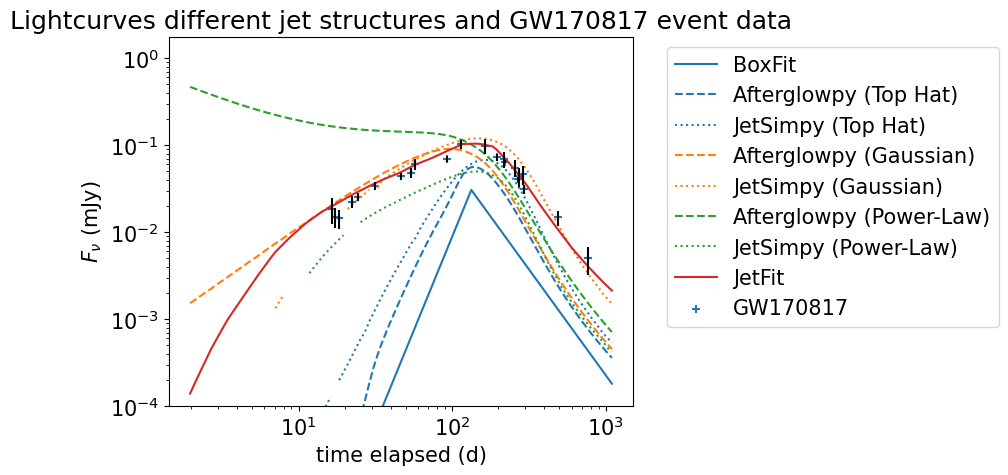

In [38]:
#Instructions for plotting the lightcurve
fig1, ax1 = plt.subplots(1, 1)

# Top Hat
ax1.plot(convert_ts_td(times_box), Fl_box, label="BoxFit") 
ax1.plot(convert_ts_td(times), afterglowpys[0][0], label="Afterglowpy (Top Hat)", color = 'tab:blue', linestyle='dashed')
ax1.plot(convert_ts_td(times), jetsimpys[0], label="JetSimpy (Top Hat)", color = 'tab:blue', linestyle='dotted') 

#Gaussian
ax1.plot(convert_ts_td(times), afterglowpys[1][0], label="Afterglowpy (Gaussian)", color = 'tab:orange', linestyle='dashed')
ax1.plot(convert_ts_td(times), jetsimpys[1], label="JetSimpy (Gaussian)", color = 'tab:orange', linestyle='dotted') 

#Power-Law
ax1.plot(convert_ts_td(times), afterglowpys[2][0], label="Afterglowpy (Power-Law)", color = 'tab:green', linestyle='dashed')
ax1.plot(convert_ts_td(times), jetsimpys[2], label="JetSimpy (Power-Law)", color = 'tab:green', linestyle='dotted') 

#Boosted fireball
ax1.plot(convert_ts_td(times), Fljet, label="JetFit", color = 'tab:red') 

#Event data with its errorbars
ax1.scatter(t_gw, Fl_gw, label = "GW170817", marker = '+')
ax1.errorbar(t_gw, Fl_gw,yerr=Flerr_gw,linestyle='', color='black')

ax1.set_title("Lightcurves different jet structures and GW170817 event data")
ax1.set(xscale='log', xlabel=r'time elapsed (d)',
       yscale='log', ylabel=r'$F_\nu$ (mJy)')

ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.set_ylim(10**-4,)
plt.subplots_adjust(right=0.85)
fig1.savefig("lightcurve_comp.pdf", bbox_inches='tight')
fig1.show()


# Appendix

Table indicating the input of each model with its units (or "." when there's no unit). 

| Input Parameter | BoxFit | Afterglowpy | JetFit | JetSimpy |
|:--------:|:--------:|:--------:| :--------:| :--------:|
|  $\theta_{obs}$   | . rad   | . rad  |   | . rad  |
|  $\theta_{j}$    | . rad   |  . rad  |   | . rad  |
|  $\theta_{wing}$    |    |  rad   |   |  |
|  $n$    | . $cm^{-3}$   | . $cm^{-3}$   | . $cm^{-3}$/1 $cm^{-3}$  | . $cm^{-3}$   |
|  $p$    |  .  |  .   | .   | .  |
|  $E$   |     |     | . erg / 10^50   |    |
|  $E_{iso}$   |  . erg   | . erg   |   | . erg   |
|  $\eta_0$   |     |    | .   |    |
|  $\gamma_B$    |     |    | .   |    |
|  $\Gamma$    |     |    |    | .  |
|  $\epsilon_B$   |  .  |  .   | .   | .  |
|  $\epsilon_E$   |  .   |  .  | .  | .  |
|  $\xi_N$   |  .  |  .   | .   |   |
|  $d_L$   |  cm   |  cm   | cm  | Mpc   |
|  $z$   |  .  |  .   | .   | .  |
|  $b$   |    |  .   |   | .  |

Second table of the inputs of each model with their values

In [31]:
import pandas as pd

# The format is the following: 
# "Model"                    : [D['thetaObs'], D['thetaCore'], D['thetaWing'], D['Eta0'], D['GammaB'], D['E'], D['Eiso'], D['n0'], D['p'], D['b'], D['epsilon_e'], D['epsilon_B'], D['xi_N'], D['d_L'], D['z']]

models = {
    "BoxFit"     : [D['theta_obs'], D['theta_0'], '', '', '', '', '', D['E'], D['n'], D['p'], '', D['epsilon_E'], D['epsilon_B'], D['ksi_N'], D['d_L'], D['z']],
    "Afterglowpy": [A['thetaObs'], A['thetaCore'], A['thetaWing'], '','', '', '', A['E0'], A['n0'], A['p'], A['b'], A['epsilon_e'], A['epsilon_B'], A['xi_N'], A['d_L'], A['z']],
    "JetFit"     : ['', '','', J['Eta0'], J['GammaB'], '', format(J['E'],'.2e'), '', J['n'], J['p'], '', J['epse'], J['epsb'], J['xiN'], J['dL'], J['z']],
    "JetSimpy"   : [JS['theta_v'], JS['theta_c'], '', '', '', JS['lf'], '', JS['Eiso'], JS['n0'], JS['p'], JS['b'], JS['eps_e'], JS['eps_b'], '', format(JS['d'],'.2e'), JS['z']]
}


variables = ['theta_obs','theta_j', 'theta_wing', 'eta_0', 'gamma_B', 'lf', 'E', 'E_iso', 'n', 'p', 'b', 'eps_e', 'eps_b', 'xi_N', 'd_L', 'z']

variables_unit_B  = [' rad', ' rad', '', '', '', '','', ' erg', ' cm^-3', '', '', '', '', '', ' cm', '']
variables_unit_A  = [' rad', ' rad', ' rad', '', '', '','', ' erg', ' cm^-3', '', '', '', '', '', ' cm', '']
variables_unit_J  = ['', '', '', '', '', '',' erg/10^50', '', '', '', '', '', '', '', ' cm/10^28', '']
variables_unit_JS = [' rad', ' rad', '', '', '', '', '',' erg', ' cm^-3', '', '', '', '', '', ' Mpc', '']

df                = pd.DataFrame(models, variables)
df['BoxFit']      = df['BoxFit'].astype(str) + variables_unit_B
df['Afterglowpy'] = df['Afterglowpy'].astype(str) + variables_unit_A
df['JetFit']      = df['JetFit'].astype(str) + variables_unit_J
df['JetSimpy']    = df['JetSimpy'].astype(str) + variables_unit_JS

print(df)

                       BoxFit        Afterglowpy              JetFit  \
theta_obs            0.44 rad           0.44 rad                       
theta_j         0.0698132 rad      0.0698132 rad                       
theta_wing                              0.88 rad                       
eta_0                                                              8   
gamma_B                                                           12   
lf                                                                     
E                                                 2.49e+00 erg/10^50   
E_iso       1.0208249e+53 erg  1.0208249e+53 erg                       
n                  0.01 cm^-3         0.01 cm^-3                0.01   
p                        2.15               2.15                2.15   
b                                            4.5                       
eps_e                     0.1                0.1                 0.1   
eps_b                   7e-06              7e-06               7

Plotting E($\theta$) for every jet structure

In [32]:
def convert_deg_to_rad(deg):
    return deg*np.pi/180

In [33]:
def convert_rad_to_deg(rad):
    return rad*180/np.pi

In [34]:
# Linspace from 0° to 40°
thetalinsp = np.linspace(0, 0.6981317007977318, 1000)

theta_c = D['theta_0']
b       = A['b']
E_iso   = D['E']
gb      = J['GammaB']
e0      = J['Eta0']


# Top Hat
E_th = np.heaviside(-thetalinsp+theta_c,thetalinsp[999]- theta_c) # Using the heaviside funcion that is 0 for x < 0 and 1 for x > 1 with x running from 1 to -9 to get only a small potion that is = 1 with sharp edges

# Gaussian
E_g = np.exp(-0.5*(thetalinsp/theta_c)**2)

# Power-Law
E_pl = ( 1 + (1/b)*(thetalinsp/theta_c)**2 )**(-b/2)

# Boosted Fireball model: using formulas found in  Wu & MacFadyen 2018
v0          = np.sqrt(1 - 1/e0**2)
vb          = np.sqrt(1 - 1/gb**2)
sin_fact    = gb*vb*np.sin(thetalinsp)
gamma_max_0 = gb*(e0 + vb*e0*v0)
gamma_max   = gb*(e0 + vb*np.cos(thetalinsp))*np.sqrt((e0*v0)**2 - sin_fact**2)/(1 + sin_fact**2)
E_bf        = (gamma_max/gamma_max_0)**3


In [35]:
def normalize_E(E):
    return E/E[0]

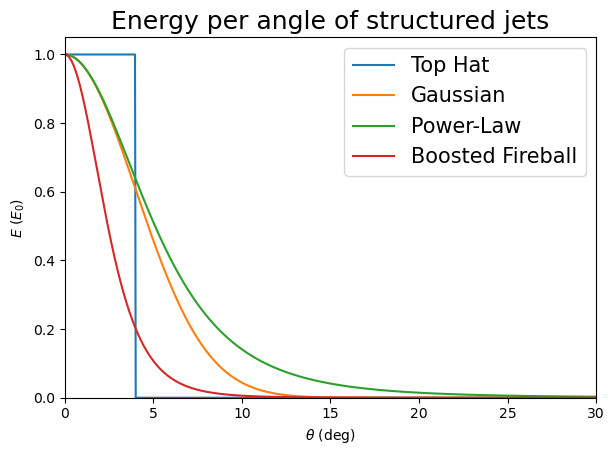

In [36]:
fig3, ax3 = plt.subplots(1, 1)
plt.rcParams.update({'font.size': 15})
ax3.plot(convert_rad_to_deg(thetalinsp), E_th, label="Top Hat")
ax3.plot(convert_rad_to_deg(thetalinsp), E_g, label="Gaussian") 
ax3.plot(convert_rad_to_deg(thetalinsp), E_pl, label="Power-Law") 
ax3.plot(convert_rad_to_deg(thetalinsp), normalize_E(E_bf), label="Boosted Fireball") 
ax3.set_xlim(0,30)
ax3.set_ylim(0,)
ax3.set_title("Energy per angle of structured jets")
ax3.set(xlabel=r'$\theta$ (deg)', ylabel=r'$E$ ($E_0$)')
ax3.legend()
plt.tight_layout()
fig3.savefig("profiles.png")